In [2]:
pip install pandas scikit-learn openpyxl matplotlib seaborn numpy==1.26.0

   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
    --------------------------------------- 0.3/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.8/15.8 MB 2.2 MB/s eta 0:00:07
   --- ------------------------------------ 1.3/15.8 MB 2.4 MB/s eta 0:00:07
   ---- ----------------------------------- 1.8/15.8 MB 2.6 MB/s eta 0:00:06
   ------ --------------------------------- 2.6/15.8 MB 2.7 MB/s eta 0:00:05
   --------- ------------------------------ 3.7/15.8 MB 3.1 MB/s eta 0:00:04
   ----------- ---------------------------- 4.5/15.8 MB 3.2 MB/s eta 0:00:04
   ------------- -------------------------- 5.5/15.8 MB 3.5 MB/s eta 0:00:03
   --------------- ------------------------ 6.3/15.8 MB 3.5 MB/s eta 0:00:03
   ------------------ --------------------- 7.3/15.8 MB 3.7 MB/s eta 0:00:03
   --------------------- ------------------ 8.4/15.8 MB 3.8 MB/s eta 0:00:02
   ----------------------- ---------------- 9.4/15.8 MB 3.9 MB/s eta 0:00:02
   ----------

In [3]:
import numpy as np
print(np.__version__)

1.26.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Загрузка данных
train_path = "train.xlsx"
test_path = "test.xlsx"

train = pd.read_excel(train_path)
test = pd.read_excel(test_path)


In [5]:
# 2. Базовый анализ данных
def analyze_data(df, name="Dataset"):
    print(f"\n{name} Info:\n")
    print(df.info())
    print("\nMissing values:\n", df.isnull().sum())
    print("\nBasic Statistics:\n", df.describe())
    print("\nFirst few rows:\n", df.head())

analyze_data(train, "Train Data")
analyze_data(test, "Test Data")



Train Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
None

Missing values:
 dt                  0
Цена на арматуру    0
dtype: int64

Basic Statistics:
                         dt  Цена на арматуру
count                  400        400.000000
mean   2018-11-01 12:00:00      39229.475000
min    2015-01-05 00:00:00      21000.000000
25%    2016-12-03 06:00:00      31075.000000
50%    2018-11-01 12:00:00      35450.000000
75%    2020-09-29 18:00:00      42000.000000
max    2022-08-29 00:00:00      79000.000000
std                    NaN      13407.979668

First few rows:
           dt  Цена на арматуру
0 2015-01-05             32900
1 2015-01-12       

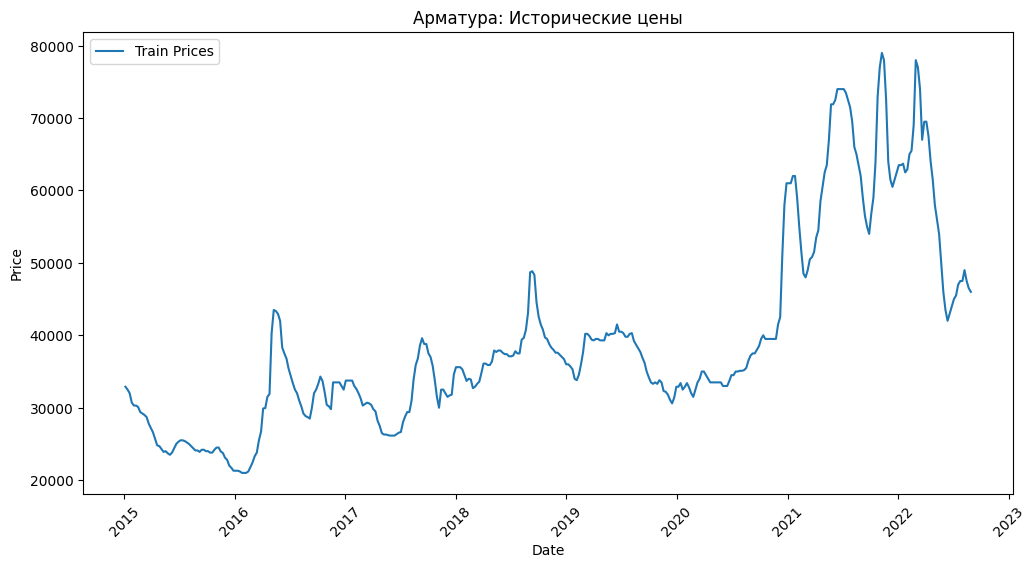

In [6]:
# 3. Визуализация временного ряда цен
plt.figure(figsize=(12, 6))
sns.lineplot(x=train["dt"], y=train["Цена на арматуру"], label="Train Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Арматура: Исторические цены")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [7]:
# 4. Добавление новых признаков
def feature_engineering(df):
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["week"] = df["dt"].dt.isocalendar().week
    df["day_of_week"] = df["dt"].dt.dayofweek
    return df


train = feature_engineering(train)
test = feature_engineering(test)


In [8]:
# Функция для добавления лагов и скользящих средних
def add_lags_and_rolling_features(df, lags=[1, 2, 3, 4], roll_windows=[2, 4]):
    df = df.copy()
    
    # Добавляем лаги (цены прошлых недель)
    for lag in lags:
        df[f'price_lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
    # Добавляем скользящие средние (усредненные цены за несколько недель)
    for window in roll_windows:
        df[f'price_roll_mean_{window}'] = df['Цена на арматуру'].rolling(window=window).mean()
    
    return df

# Добавляем признаки к processed_train и processed_test
train = add_lags_and_rolling_features(train)
test = add_lags_and_rolling_features(test)

In [9]:
# 5. Сохранение обработанных данных
train.to_csv("processed_train.csv", index=False)
test.to_csv("processed_test.csv", index=False)

print("Предобработка завершена. Данные сохранены.")


Предобработка завершена. Данные сохранены.


In [10]:
pip install catboost

   ---------------------------------------- 0.0/101.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/101.8 MB 2.4 MB/s eta 0:00:43
   ---------------------------------------- 1.0/101.8 MB 2.5 MB/s eta 0:00:40
    --------------------------------------- 1.6/101.8 MB 2.6 MB/s eta 0:00:39
    --------------------------------------- 2.4/101.8 MB 2.6 MB/s eta 0:00:39
   - -------------------------------------- 2.9/101.8 MB 2.7 MB/s eta 0:00:37
   - -------------------------------------- 3.4/101.8 MB 2.7 MB/s eta 0:00:37
   - -------------------------------------- 3.9/101.8 MB 2.6 MB/s eta 0:00:38
   - -------------------------------------- 4.5/101.8 MB 2.7 MB/s eta 0:00:36
   - -------------------------------------- 5.0/101.8 MB 2.6 MB/s eta 0:00:38
   - -------------------------------------- 5.0/101.8 MB 2.6 MB/s eta 0:00:38
   -- ------------------------------------- 5.8/101.8 MB 2.5 MB/s eta 0:00:39


0:	learn: 2174.5757574	test: 7244.2424274	best: 7244.2424274 (0)	total: 876us	remaining: 700ms
100:	learn: 626.8621419	test: 2797.6063202	best: 2797.6063202 (100)	total: 56.5ms	remaining: 391ms
200:	learn: 306.0168083	test: 2417.7289146	best: 2412.1851915 (194)	total: 116ms	remaining: 347ms
300:	learn: 184.3887398	test: 2344.7003562	best: 2344.1847490 (298)	total: 188ms	remaining: 311ms
400:	learn: 110.1228299	test: 2342.3532842	best: 2334.0732759 (364)	total: 266ms	remaining: 265ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2334.073276
bestIteration = 364

Shrink model to first 365 iterations.
0:	learn: 3951.7878793	test: 8935.5151523	best: 8935.5151523 (0)	total: 889us	remaining: 711ms
100:	learn: 1131.7176927	test: 4726.1203072	best: 4726.1203072 (100)	total: 78.1ms	remaining: 540ms
200:	learn: 719.3496348	test: 3992.6180478	best: 3992.6180478 (200)	total: 154ms	remaining: 458ms
300:	learn: 500.8838708	test: 3786.3669013	best: 3786.3669013 (300)	total: 242ms	

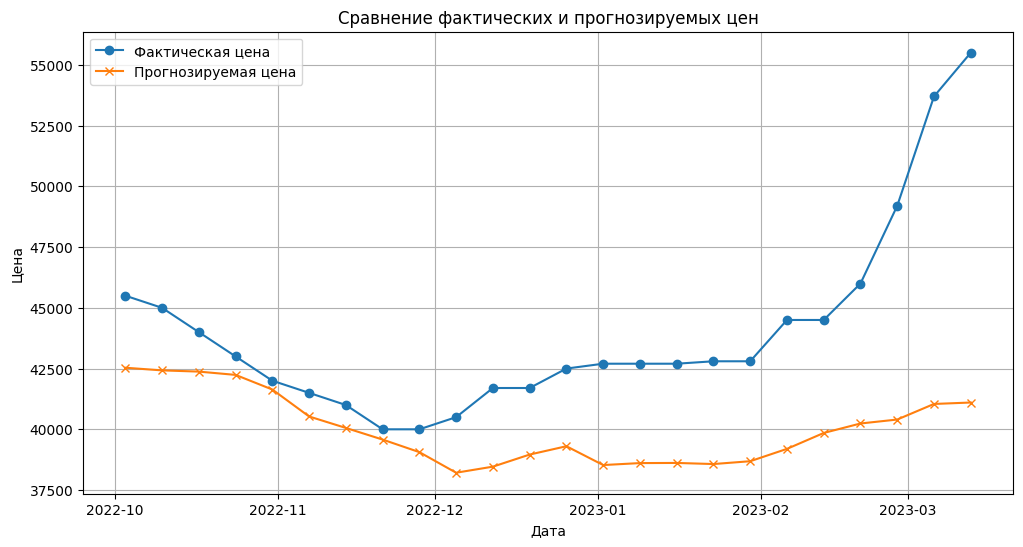

          dt  predicted_price  recommended_weeks
4 2022-10-03     42534.605736                  1
5 2022-10-10     42425.549507                  1
6 2022-10-17     42375.036321                  1
7 2022-10-24     42239.613238                  1
8 2022-10-31     41637.272015                  1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit

# Функция для генерации лагов и скользящих средних
def create_features(df, lag_weeks=[1, 2, 3, 4], rolling_weeks=[2, 4]):
    df = df.copy()
    for lag in lag_weeks:
        df[f'price_lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    for window in rolling_weeks:
        df[f'price_roll_mean_{window}'] = df['Цена на арматуру'].shift(1).rolling(window).mean()
    df.dropna(inplace=True)  # Убираем строки с NaN (из-за лагов)
    return df

# Загрузка данных
train = pd.read_csv("processed_train.csv", parse_dates=["dt"]).sort_values("dt")
test = pd.read_csv("processed_test.csv", parse_dates=["dt"]).sort_values("dt")

# Генерация признаков
train = create_features(train)
test = create_features(test)

# Разделяем признаки и целевую переменную
X_train, y_train = train.drop(columns=["dt", "Цена на арматуру"]), train["Цена на арматуру"]
X_test, y_test = test.drop(columns=["dt", "Цена на арматуру"]), test["Цена на арматуру"]

# Кросс-валидация по времени
ts_cv = TimeSeriesSplit(n_splits=5)

# Обучение модели
model = CatBoostRegressor(
    iterations=800,         
    depth=5,                
    learning_rate=0.02,     
    l2_leaf_reg=30,         
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    early_stopping_rounds=100,
    random_strength=5,
    bagging_temperature=1.5,
    subsample=0.8,         
    colsample_bylevel=0.8,
    grow_policy="Depthwise", 
    verbose=100
)

best_model = None
best_score = float("inf")

# Обучение с кросс-валидацией
for train_idx, test_idx in ts_cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]
    train_pool = Pool(X_tr, y_tr)
    test_pool = Pool(X_val, y_val)
    
    model.fit(train_pool, eval_set=test_pool)
    
    val_score = model.get_best_score()["validation"]["MAE"]
    if val_score < best_score:
        best_score = val_score
        best_model = model.copy()

# Прогноз на тестовой выборке
test["predicted_price"] = best_model.predict(X_test)

# Генерация рекомендаций
test["recommended_weeks"] = np.where(
    test["predicted_price"] > test["predicted_price"].shift(1), 6, 1
)

# Визуализация фактических и предсказанных цен
plt.figure(figsize=(12, 6))
plt.plot(test["dt"], test["Цена на арматуру"], label="Фактическая цена", marker="o")
plt.plot(test["dt"], test["predicted_price"], label="Прогнозируемая цена", marker="x")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Сравнение фактических и прогнозируемых цен")
plt.legend()
plt.grid()
plt.show()

# Вывод результатов
print(test[["dt", "predicted_price", "recommended_weeks"]].head())


In [ ]:
import matplotlib.pyplot as plt

# Предполагаем, что test содержит 'price' (фактические цены) и 'predicted_price' (прогноз)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test["price"], label="Фактическая цена", marker="o")
plt.plot(test.index, test["predicted_price"], label="Прогнозируемая цена", marker="x")

plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Сравнение фактических и прогнозируемых цен")
plt.legend()
plt.grid()
plt.show()


In [12]:
pip install pmdarima statsmodels


   ---------------------------------------- 0.0/613.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/613.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/613.3 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/613.3 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/613.3 kB ? eta -:--:--
   -------------------------------------- 613.3/613.3 kB 681.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 837.5 kB/s eta 0:00:12
   --- ------------------------------------ 0.8/9.8 MB 799.2 kB/s eta 0:00:12
   --- ------------------------------------ 0.8/9.8 MB 799.2 kB/s eta 0:00:12
   ---- ----------------------------------- 1.0/9.8

c:\Users\User\Desktop\intens3-main\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\Desktop\intens3-main\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\Desktop\intens3-main\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Цена на арматуру   No. Observations:                  400
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3487.541
Date:                Wed, 19 Mar 2025   AIC                           6981.082
Time:                        13:59:18   BIC                           6993.049
Sample:                    01-05-2015   HQIC                          6985.821
                         - 08-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3781      0.099      3.838      0.000       0.185       0.571
ma.L1          0.0016      0.115      0.014      0.989      -0.223       0.226
sigma2      1.988e+06   5.35e+04     37.130      0.0

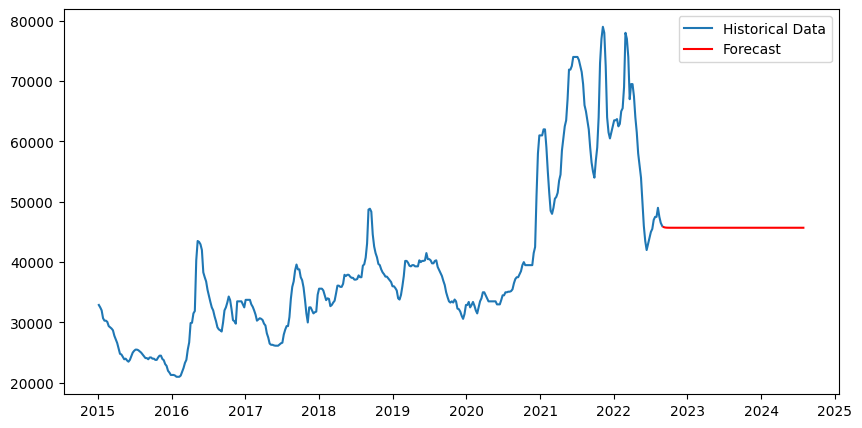

In [32]:
# Импорт необходимых библиотек
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Загрузка данных из Excel
# Убедитесь, что путь к вашему файлу train.xlsx указан правильно
file_path = 'train.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Предполагаем, что даты в колонке 'A' и значения в колонке 'B'
data['dt'] = pd.to_datetime(data['dt'])  # Преобразуем колонки в даты
data.set_index('dt', inplace=True)  # Устанавливаем даты в качестве индекса

# Обучение модели ARIMA
model = sm.tsa.ARIMA(data['Цена на арматуру'], order=(1, 1, 1))  # Задайте параметры p, d, q
model_fit = model.fit()

# Вывод результатов
print(model_fit.summary())

# Прогнозирование
forecast = model_fit.forecast(steps=100)  # Прогнозирование на 5 шагов вперед
print(forecast)

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(data['Цена на арматуру'], label='Historical Data')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()